# Dependencies

Let's import any necessary dependencies.

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
from IPython.display import display
from matplotlib.cm import viridis
from collections import Counter
from gensim.models import Word2Vec
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.manifold import TSNE
from whoosh.index import create_in
from whoosh.fields import Schema, TEXT
from whoosh.qparser import QueryParser


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/usi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/usi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/usi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Investigate dataset

In this first part, we will analyse the dataset in order to fully understand its properties and characteristics.

In [3]:
splits = [f"hf://datasets/timdettmers/openassistant-guanaco/openassistant_best_replies_{s}.jsonl" for s in ['train', 'eval']]
df_train = pd.read_json(splits[0], lines=True)
df_test = pd.read_json(splits[1], lines=True)

In [4]:
def highlight(s):
    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'
    return color.YELLOW + s + color.END

# PRINT SOME INFO
print(highlight('Number of rows (train/test/total):'), f"{len(df_train)}/{len(df_test)}/{len(df_train) + len(df_test)}")
print(highlight("Head of the dataset"), df_train.head(5))
print(highlight("Example train row:"))
print(df_train.iloc[0]["text"])
print(highlight("Example train row:"))
print(df_test.iloc[0]["text"])
print("")

Number of rows (train/test/total): 9846/518/10364
Head of the dataset                                                 text
0  ### Human: Can you write a short introduction ...
1  ### Human: ¿CUales son las etapas del desarrol...
2  ### Human: Can you explain contrastive learnin...
3  ### Human: I want to start doing astrophotogra...
4  ### Human: Método del Perceptrón biclásico: de...
Example train row:
### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities 

Now, we can extract other interesting parameters such as how many languages exist within and how they are distributed. To do this, we need to use existing libraries such as `langdetect`.


In [20]:
def plot_language_distribution(df, dataset=""):
    def detect_language(text):
        try:
            return detect(text)
        except:
            return "unknown"

    df["language"] = df["text"].apply(detect_language)
    language_distribution = df["language"].value_counts().reset_index()
    language_distribution.columns = ["language", "count"]

    total_languages = language_distribution["language"].nunique()

    plt.figure(figsize=(10, 6))
    plt.bar(language_distribution["language"], language_distribution["count"], color=plt.cm.tab20.colors)
    plt.title(f"Language Distribution in {dataset} Dataset (Total Languages: {total_languages})", fontsize=16)
    plt.xlabel("Language", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Total Languages:", total_languages)

Train Dataset


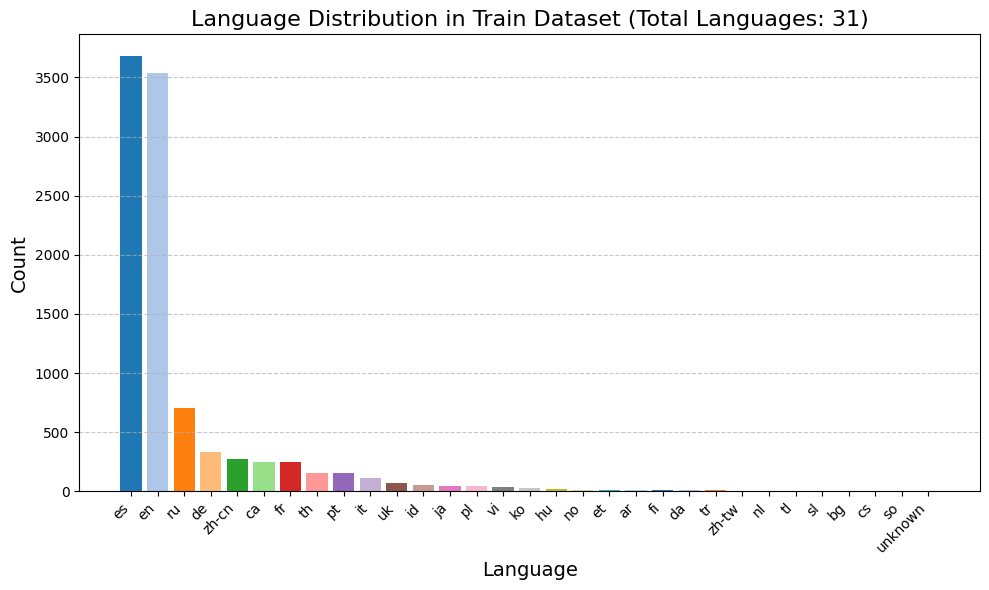

Total Languages: 31


In [21]:
print("Train Dataset")
plot_language_distribution(df_train, dataset="Train")

Test Dataset


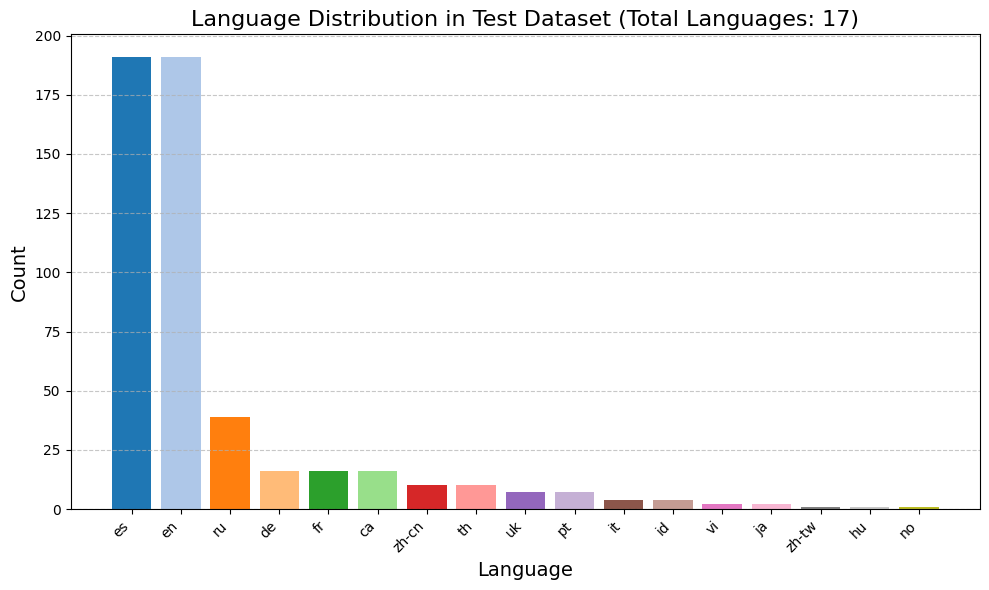

Total Languages: 17


In [22]:
print("Test Dataset")
plot_language_distribution(df_test, dataset="Test")

We can also analyse are the lengths i.e how long on average the users' sentences and assistant's replies are.

In [9]:

splits = [f"hf://datasets/timdettmers/openassistant-guanaco/openassistant_best_replies_{s}.jsonl" for s in ['train', 'eval']]
df_train = pd.read_json(splits[0], lines=True)
df_test = pd.read_json(splits[1], lines=True)
def len_computation(df):
    def extract_lengths(text):
        segments = text.split("### Human:")
        human_lengths = []
        assistant_lengths = []
        
        for segment in segments[1:]: 
            try:
                human, assistant = segment.split("### Assistant:")
                human_lengths.append(len(human.strip()))
                assistant_lengths.append(len(assistant.strip()))
            except ValueError:
                human_lengths.append(len(segment.strip()))
        
        return human_lengths, assistant_lengths

    lengths = df["text"].apply(extract_lengths)

    df["human_lengths"] = lengths.apply(lambda x: x[0])
    df["assistant_lengths"] = lengths.apply(lambda x: x[1])

    all_human_lengths = [length for sublist in df["human_lengths"] for length in sublist]
    all_assistant_lengths = [length for sublist in df["assistant_lengths"] for length in sublist]

    human_mean = sum(all_human_lengths) / len(all_human_lengths)
    human_std = (sum((x - human_mean) ** 2 for x in all_human_lengths) / len(all_human_lengths)) ** 0.5

    assistant_mean = sum(all_assistant_lengths) / len(all_assistant_lengths)
    assistant_std = (sum((x - assistant_mean) ** 2 for x in all_assistant_lengths) / len(all_assistant_lengths)) ** 0.5

    print(f"Mean len for Human:         {human_mean:.2f},      Std: {human_std:.2f}")
    print(f"Mean len for Assistant:     {assistant_mean:.2f},     Std: {assistant_std:.2f}")

print("Train dataset:")
len_computation(df_train)

print("\nTest dataset:")
len_computation(df_test)


Train dataset:
Mean len for Human:         118.32,      Std: 229.61
Mean len for Assistant:     892.96,     Std: 783.82

Test dataset:
Mean len for Human:         138.84,      Std: 416.00
Mean len for Assistant:     889.69,     Std: 800.43


Furthermore, we can extract the dictionary of the interactions and see the number of words. Let's do this only for the training dataset just to get a rough idea how of how this might look like.

In [7]:
def extract_dictionary(df, language=None):
    def clean_text(text):
        return re.sub(r'[^\w\s]', '', text).lower()

    df['clean_text'] = df['text'].fillna('').apply(clean_text)

    word_counts = Counter()

    for text in df['clean_text']:
        if language is None or detect(text) == language:
            word_counts.update(text.split())

    return dict(word_counts)

dictionary_train = extract_dictionary(df_train)
dictionary_train_en = extract_dictionary(df_train, language="en")
print("Number of unique words in train dataset (English/total)", f"{len(dictionary_train_en)}/{len(dictionary_train)}")

Number of unique words in train dataset (English/total) 45475/155992


Test just to get an idea of how many words in English there are

In [8]:
stemmer = PorterStemmer()
print("Number of unique words in train dataset (only English):")
dict_train_stemmed = {stemmer.stem(word): count for word, count in dictionary_train_en.items()}
print("1. After stemming:                                 ", len(dict_train_stemmed))

lemmatizer = WordNetLemmatizer()
dict_train_lemmatized = {lemmatizer.lemmatize(word): count for word, count in dict_train_stemmed.items()}
print("2. After lemmatizing:                              ", len(dict_train_lemmatized))

dictionary_train_alpha = {word: count for word, count in dict_train_lemmatized.items() if not word.isnumeric() and word.isalpha()}
print("3. After removing numbers and non-alphabetic words:", len(dictionary_train_alpha))


Number of unique words in train dataset (only English):
1. After stemming:                                  34550
2. After lemmatizing:                               34476
3. After removing numbers and non-alphabetic words: 27543


# Word2Vec

In [9]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

languages = ['english', 'spanish', 'french', 'russian', 'catalan']
all_stopwords = {word for lang in languages for word in stopwords.words(lang)}

def tokenizer(text, remove_stopwords=True, use_stemming=True, use_lemmatization=True):
    text = text.lower()                     # convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)    # remove non-alphabetic characters
    tokens = text.split()                   # split into words

    if remove_stopwords:
        tokens = [word for word in tokens if word not in all_stopwords and len(word) > 2]
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

print(highlight("Original text:"))
print(df_train.iloc[0]["text"])
print(highlight("Tokenized text:"))
print(tokenizer(df_train.iloc[0]["text"], remove_stopwords=True, use_stemming=False, use_lemmatization=False))

Original text:
### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.

Recent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining

In [10]:
df_train['tokens'] = df_train['text'].apply(tokenizer)
sentences = df_train['tokens'].tolist()

word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)
word2vec.save("Models/word2ve.model")

In [11]:
word2vec = Word2Vec.load("Models/word2ve.model")
vocab = list(word2vec.wv.index_to_key)
print(highlight("Vocabulary size:"), len(vocab))
print(highlight("Sample words in the vocabulary:             "), vocab[:10])

similar_words = word2vec.wv.most_similar("program", topn=10)
print(highlight("Words most similar to 'program':            "), similar_words)
similarity = word2vec.wv.similarity("program", "python")
print(highlight("Similarity between 'program' and 'python':  "), similarity)

Vocabulary size: 44279
Sample words in the vocabulary:              ['human', 'assist', 'use', 'pued', 'make', 'help', 'die', 'import', 'like', 'also']
Words most similar to 'program':             [('objectori', 0.8863467574119568), ('compil', 0.8542766571044922), ('prolog', 0.8520537614822388), ('paradigm', 0.8479042649269104), ('jit', 0.8478630185127258), ('oop', 0.8463621139526367), ('lowlevel', 0.8397777080535889), ('highlevel', 0.8371989130973816), ('justintim', 0.8371079564094543), ('concurr', 0.8348135948181152)]
Similarity between 'program' and 'python':   0.5901036


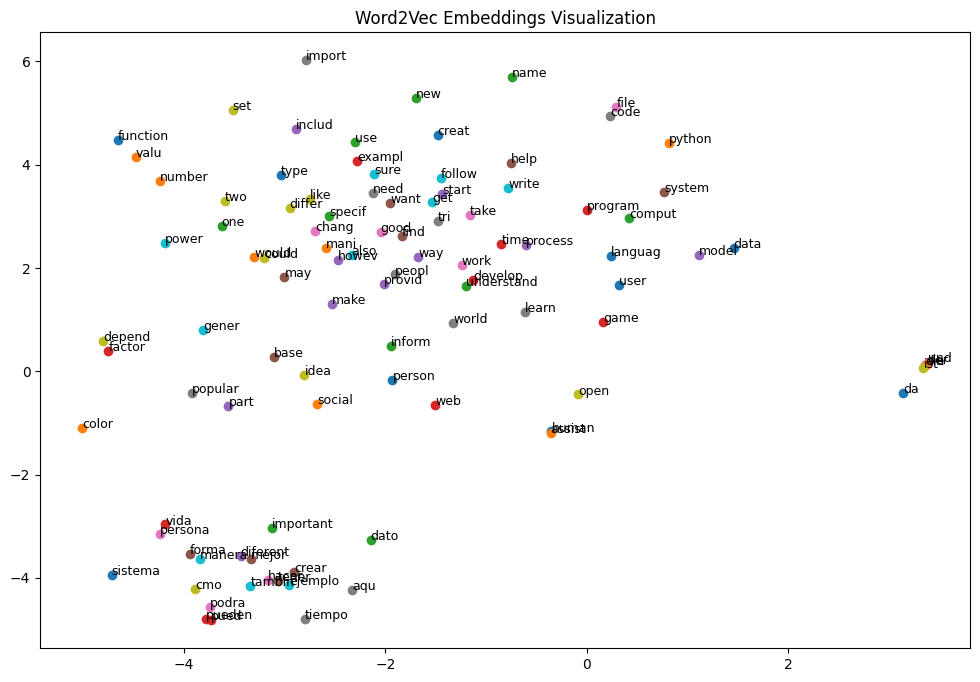

In [12]:
words = list(word2vec.wv.index_to_key)[:100]
word_vectors = [word2vec.wv[word] for word in words]
word_vectors = np.array([word2vec.wv[word] for word in words])

tsne = TSNE(n_components=2, random_state=42, perplexity=30) 
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=9)
plt.title("Word2Vec Embeddings Visualization")
plt.show()

# Indexing the documents

In [13]:
schema = Schema(title=TEXT(stored=True), content=TEXT(stored=True))

if not os.path.exists("index"):
    os.mkdir("index")
index = create_in("index", schema)

def index_documents(documents):
    writer = index.writer()
    for i, doc in enumerate(documents):
        writer.add_document(title=f"Document {i+1}", content=doc)
    writer.commit()

dataset_documents = df_test[df_test['language'] == 'en']['text'].tolist()
index_documents(dataset_documents)
print("Documents indexed successfully!")

Documents indexed successfully!


In [14]:
def search_documents(keyword):
    with index.searcher() as searcher:
        query_parser = QueryParser("content", index.schema)
        query = query_parser.parse(keyword)
        results = searcher.search(query)

        print(f"Search results for '{keyword}':")
        for result in results:
            print(highlight(f"- {result['title']}"), result['content'])

In [15]:
search_keyword = "machine learning" 
search_documents(search_keyword)

Search results for 'machine learning':
- Document 142 ### Human: Explain how it might be possible to host a large learning model on an average computer. Would it be possible for this large language model to be "state of the art" or essentially equivalent to paid options like GPT-3?### Assistant: It is possible to host a large learning model on an average computer through the use of distributed training and efficient data storage techniques. By using distributed training, the computational load can be spread across multiple machines, reducing the burden on any one individual computer. Additionally, efficient data storage techniques, such as using compressed data formats, can help to reduce the storage requirements of the model.

However, it is important to note that the size of a state-of-the-art language model like GPT-3 can be in the order of hundreds of gigabytes, and the computational requirements for training such a model can be enormous. While it may be possible to host a smaller 

In [16]:
def interactive_search():
    search_box = widgets.Text(description="Keyword:")
    output = widgets.Output()

    def on_search(change):
        output.clear_output()
        with output:
            search_documents(change.new)

    search_box.observe(on_search, names='value')
    display(search_box, output)

interactive_search()

Text(value='', description='Keyword:')

Output()